## Loading dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import *
from gensim.models.phrases import Phraser, Phrases
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve,classification_report,average_precision_score, precision_recall_fscore_support
from sklearn import metrics
from sklearn import cross_validation
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
Data = pd.read_csv('data.csv')

In [3]:
Data.head()

,content,sentiment
0,"Great fun!, Got these last Christmas as a gag ...",1
1,"Inspiring, I hope a lot of people hear this cd...",1
2,"Great CD, My lovely Pat has one of the GREAT v...",1
3,"First album I've bought since Napster, We've c...",1
4,"Amazing!, I used to find myself starting Chron...",1


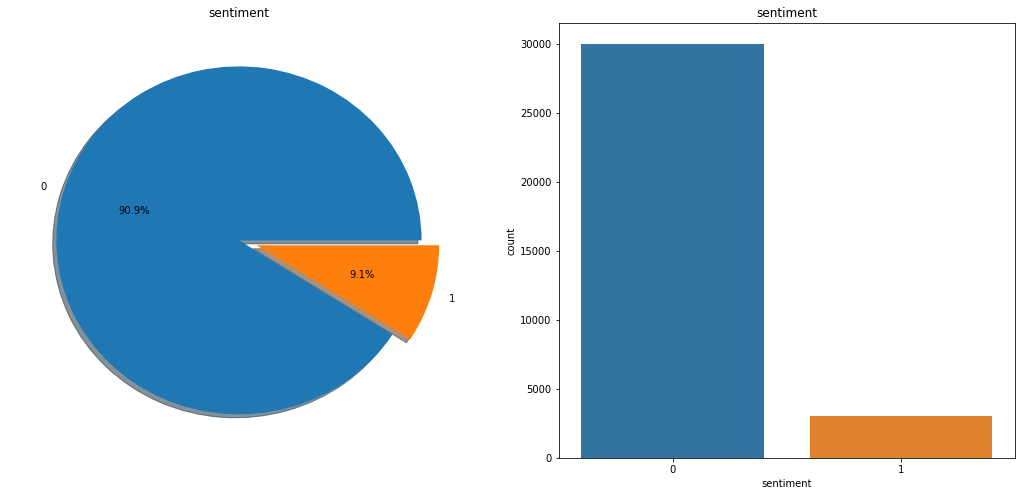

In [4]:
f,ax=plt.subplots(1,2,figsize=(18,8))
Data['sentiment'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('sentiment')
ax[0].set_ylabel('')
sns.countplot('sentiment',data=Data,ax=ax[1])
ax[1].set_title('sentiment')
plt.show()

## Cleaning Texts

In [5]:
Data.content = Data.content.apply(lambda x: x.lower())
Data.content = Data.content.apply(lambda x : " ".join(re.findall('[\w]+',x)))

In [6]:
stop_words= stopwords.words('english')
def remove_stopWords(text):
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

Data.content = Data.content.apply(lambda x: remove_stopWords(x))

In [7]:
Data.head()

,content,sentiment
0,great fun got last christmas gag gift great fu...,1
1,inspiring hope lot people hear cd need strong ...,1
2,great cd lovely pat one great voices generatio...,1
3,first album bought since napster come long way...,1
4,amazing used find starting chrono cross time t...,1


In [8]:
# encoding the target variable using labelencoder
y = Data['sentiment']
LE = LabelEncoder()
y_LE = LE.fit_transform(y)
X = Data['content'].values.copy()

In [9]:
len(X), len(y)

(33000, 33000)

## Changing to vectors

In [10]:
X_counts = CountVectorizer().fit_transform(X)
X_counts.shape

(33000, 53871)

In [11]:
X_counts_tdidf = TfidfTransformer(use_idf = True).fit_transform(X_counts)
X_counts_tdidf.shape

(33000, 53871)

## Modeling

###### Splitting into train and test

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y_LE, test_size = 0.3)

### 1: Random Forest

###### Using the defualt parameters

In [13]:
# The class weight of the classifier is set to balanced
RF_model = Pipeline([('vect', CountVectorizer()), 
                      ('tfidf', TfidfTransformer()), 
                      ('clf', RandomForestClassifier(n_jobs=-1, 
                                                     #max_features='sqrt', 
                                                     oob_score = True,
                                                     class_weight='balanced',
                                                     random_state = 46))])
fit_RFmodel = RF_model.fit(x_train, y_train)
RF_predicted = fit_RFmodel.predict(x_test)
RF_conf_mat=confusion_matrix(y_test, RF_predicted)
print ("Accuracy : " + str(np.mean(RF_predicted == y_test)))

/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy : 0.9278787878787879


###### The accuracy value of

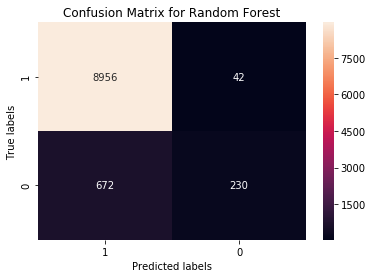

In [14]:
ax= plt.subplot()
sns.heatmap(RF_conf_mat, annot=True,fmt="d", ax = ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Random Forest'); 
ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);

In [15]:
print(metrics.classification_report(y_test, RF_predicted))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96      8998
          1       0.85      0.25      0.39       902

avg / total       0.92      0.93      0.91      9900



 As you can see the overall accuracy is good, but recall and f1-score for the miniority class is very low.

###### Tuning Random Forest hyperparameters 

In [16]:
RF_parameters = {'clf__max_depth': [3,None],
                 'clf__min_samples_leaf': [2, 5, 10]}

In [17]:
RF_GridSearch = GridSearchCV(estimator=RF_model, param_grid=RF_parameters,cv= 5)
RF_GridSearch = RF_GridSearch.fit(x_train, y_train)

/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

In [18]:
print(RF_GridSearch.best_score_)
RF_BestGrid = RF_GridSearch.best_params_
print(RF_BestGrid)

0.9345887445887446
{'clf__max_depth': None, 'clf__min_samples_leaf': 2}


In [19]:
Best_RF_model = Pipeline([('vect', CountVectorizer()), 
                      ('tfidf', TfidfTransformer()), 
                      ('clf', RandomForestClassifier(n_jobs=-1, 
                                                     max_features='auto',
                                                     max_depth = None,
                                                     min_samples_leaf = 2,
                                                     min_samples_split = 2,
                                                     oob_score = True,
                                                     class_weight='balanced',
                                                     random_state = 46))])
Best_fit_RFmodel = RF_model.fit(x_train, y_train)

/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [20]:
Best_RF_predicted = Best_fit_RFmodel.predict(x_test)
Best_RF_conf_mat=confusion_matrix(y_test, Best_RF_predicted)
print ("Accuracy : " + str(np.mean(Best_RF_predicted == y_test)))

Accuracy : 0.9278787878787879


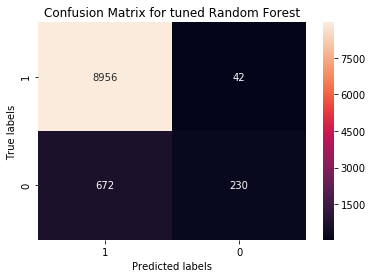

In [21]:
ax= plt.subplot()
sns.heatmap(Best_RF_conf_mat, annot=True,fmt="d", ax = ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for tuned Random Forest'); 
ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);

In [22]:
print(metrics.classification_report(y_test, Best_RF_predicted))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96      8998
          1       0.85      0.25      0.39       902

avg / total       0.92      0.93      0.91      9900



 The model doesn't improve after tuning the model

In [23]:
FP_BestRF, TP_BestRF, TH_BestRF = roc_curve(y_test, Best_RF_predicted)
ROC_BestRF = auc(FP_BestRF, TP_BestRF)
Precision_BestRF, Recall_BestRF, th_BestRF = precision_recall_curve(y_test, Best_RF_predicted)

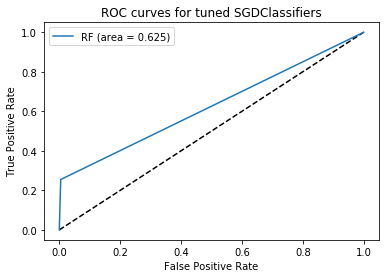

In [24]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FP_BestRF, TP_BestRF, label='RF (area = %0.3f)' % ROC_BestRF)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for tuned SGDClassifiers')
plt.legend(loc='best')
plt.show()

### 2: SVM

###### Using default parameters

In [25]:
# Again the class weight parameter is set to balanced
SVM_model = Pipeline([('vect', CountVectorizer()), 
                      ('tfidf', TfidfTransformer()), 
                      ('clf', SGDClassifier(class_weight='balanced',random_state = 46))])
fit_SVMmodel = SVM_model.fit(x_train, y_train)
SVM_predicted = fit_SVMmodel.predict(x_test)
SVM_conf_mat=confusion_matrix(y_test, SVM_predicted)
print ("Accuracy : " + str(np.mean(SVM_predicted == y_test)))

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy : 0.9542424242424242


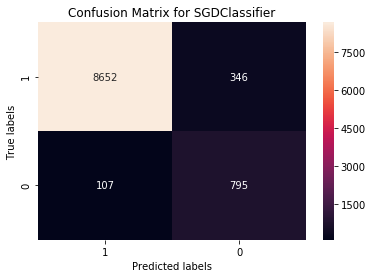

In [26]:
ax= plt.subplot()
sns.heatmap(SVM_conf_mat, annot=True,fmt="d", ax = ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for SGDClassifier'); 
ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);

In [27]:
print(metrics.classification_report(y_test, SVM_predicted))

             precision    recall  f1-score   support

          0       0.99      0.96      0.97      8998
          1       0.70      0.88      0.78       902

avg / total       0.96      0.95      0.96      9900



SVM model performs better than random forest in terms of accuracy, precision and f1-score

###### tuning SVM

In [28]:
SVM_parameters = {
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.00001,0.0001, 0.001,0.01),
    'clf__penalty': ('l2', 'elasticnet')
}

In [29]:
SVM_pipeline = Pipeline([('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

In [30]:
SVM_GridSearch = GridSearchCV(SVM_pipeline, SVM_parameters, cv=None)

In [31]:
SVM_GridSearch=SVM_GridSearch.fit(x_train, y_train)

In [32]:
print(SVM_GridSearch.best_score_)
print(SVM_GridSearch.best_params_)

0.9617748917748917
{'clf__penalty': 'l2', 'tfidf__use_idf': True, 'clf__alpha': 1e-05}


In [33]:
Best_SVM_model = Pipeline([('vect', CountVectorizer()), 
                      ('tfidf', TfidfTransformer()), 
                      ('clf', SGDClassifier(penalty = 'elasticnet',
                                           alpha=0.00001,
                                           fit_intercept=True,
                                           class_weight='balanced',
                                            random_state = 46))])

In [34]:
Best_fit_SVMmodel = Best_SVM_model.fit(x_train, y_train)
Best_SVM_predicted = Best_fit_SVMmodel.predict(x_test)
Best_SVM_conf_mat=confusion_matrix(y_test, Best_SVM_predicted)
print ("Accuracy : " + str(np.mean(Best_SVM_predicted == y_test)))

Accuracy : 0.9542424242424242


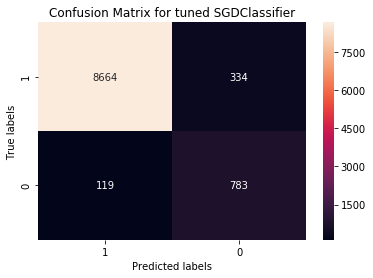

In [35]:
ax= plt.subplot()
sns.heatmap(Best_SVM_conf_mat, annot=True,fmt="d", ax = ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for tuned SGDClassifier'); 
ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);

In [36]:
print(metrics.classification_report(y_test, Best_SVM_predicted))

             precision    recall  f1-score   support

          0       0.99      0.96      0.97      8998
          1       0.70      0.87      0.78       902

avg / total       0.96      0.95      0.96      9900



 After tuning accuracy, recall and f1-score shows improvment, however precision slightly decreased.

In [37]:
FP_BestSVM, TP_BestSVM, TH_BestSVM = roc_curve(y_test, Best_SVM_predicted)
ROC_BestSVM = auc(FP_BestSVM, TP_BestSVM)
Precision_BestSVM, Recall_BestSVM, th_BestSVM = precision_recall_curve(y_test, Best_SVM_predicted)

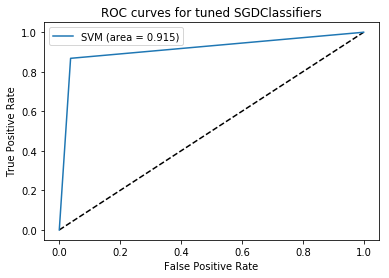

In [38]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FP_BestSVM, TP_BestSVM, label='SVM (area = %0.3f)' % ROC_BestSVM)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for tuned SGDClassifiers')
plt.legend(loc='best')
plt.show()

### 3: Deep Learning

In [39]:
num_max = 1000
LE = LabelEncoder()
y_LE = LE.fit_transform(y)
X_tok = Tokenizer(num_words=num_max)
X_tok.fit_on_texts(X)
X_mat = X_tok.texts_to_matrix(X,mode='count')

In [40]:
# Deep learning architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(num_max,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [41]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
# Fit the model
history = model.fit(X_mat, y_LE, validation_split=0.3, epochs=40, batch_size=100, verbose=0)

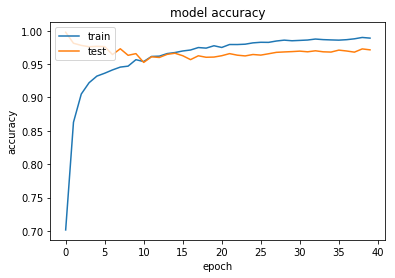

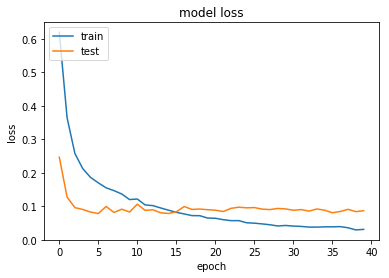

In [43]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 The performance of the model increases after adding additional hidden layer, increasing number of epochs.

##### Finally we can use SVM or deep neural network. Both have good accuracy and ROC 